## Overfitting, Underfitting and Generalization (with a Neural Network)

Until now we have mostly looked at how well a model performs on data it has seen
(**training data**) and on separate unseen data (**validation data**).

This brings us to one of the most important ideas in machine learning:

> A good model is not one that fits the training data perfectly,  
> it is one that **generalizes** well to new, unseen data.

To understand this, we need to talk about:

- **Underfitting**
- **Overfitting**
- **The region in between**

X shape: (1000, 2)
y shape: (1000,)


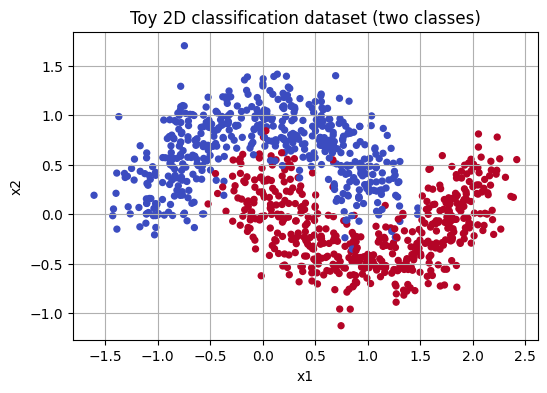

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

rng = np.random.default_rng(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
from sklearn.datasets import make_moons
# N samples from a 2D "moons" dataset (two interleaving half circles)
N = 1000
X, y = make_moons(n_samples=N, noise=0.2, random_state=1)

print("X shape:", X.shape)
print("y shape:", y.shape)
np.unique(y, return_counts=True)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy 2D classification dataset (two classes)")
plt.show()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

### 🔍 What is underfitting?

A model **underfits** when it is too simple to capture the structure in the data.

- It cannot learn the underlying relationship
- It performs poorly on **training** data
- It also performs poorly on **validation** data

Example intuition:
- Trying to fit a straight line to a curved dataset.
- Model has **too little capacity**.

### What is overfitting?

A model **overfits** when it is *too flexible* and starts memorizing the training data,
including noise and random fluctuations.

- It performs extremely well on **training** data
- But performs worse on **validation** data
- It learns details that do **not generalize**

In science, this is particularly dangerous:
- the model may "learn" simulation artefacts
- detector quirks
- noise patterns
- instead of learning **real physics**

### The ideal case

We want a model that:

- fits training data reasonably well
- performs *similarly well* on validation data

This is what we call:

> **good generalization**


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def make_reasonable_model():
    model = Sequential([
        Dense(20, activation="tanh", input_shape=(2,)),
        Dense(20, activation="tanh"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline_model = make_reasonable_model()

history_base = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    verbose=0
)

print("Baseline model:")
print("Train accuracy:", history_base.history["accuracy"][-1])
print("Val accuracy:  ", history_base.history["val_accuracy"][-1])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline model:
Train accuracy: 0.9657142758369446
Val accuracy:   0.9666666388511658


### We will now compare:

- a **reasonable network** (moderate number of neurons, some regularization)
- an **overpowered network** (large, flexible, almost no regularization)

We will look at:

- training accuracy
- validation accuracy
- decision boundaries

and see how behavior changes.

In [7]:
def make_overfitting_model():
    model = Sequential([
        Dense(100, activation="tanh", input_shape=(2,)),
        Dense(100, activation="tanh"),
        Dense(100, activation="tanh"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

overfit_model = make_overfitting_model()

history_over = overfit_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    verbose=0
)

print("Overfitting model:")
print("Train accuracy:", history_over.history["accuracy"][-1])
print("Val accuracy:  ", history_over.history["val_accuracy"][-1])


Overfitting model:
Train accuracy: 0.9614285826683044
Val accuracy:   0.9599999785423279


In [8]:
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_train_pred_base = predict_labels(baseline_model, X_train)
y_val_pred_base   = predict_labels(baseline_model, X_val)

y_train_pred_over = predict_labels(overfit_model, X_train)
y_val_pred_over   = predict_labels(overfit_model, X_val)


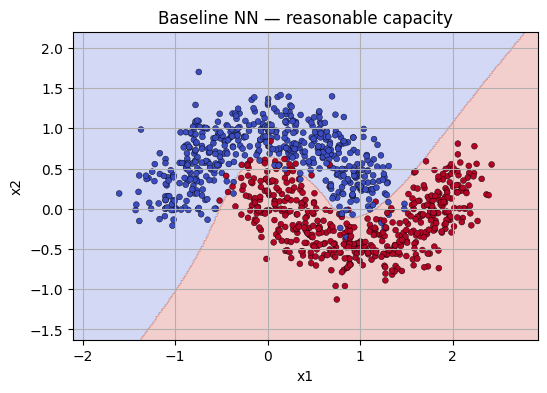

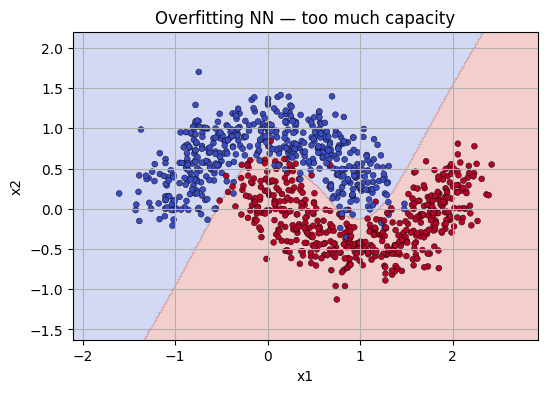

In [9]:
def plot_decision_boundary_nn(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    proba = model.predict(grid, verbose=0)
    zz = (proba > 0.5).astype(int).ravel().reshape(xx.shape)

    plt.contourf(xx, yy, zz, alpha=0.25, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=18, edgecolor="k", linewidth=0.3)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary_nn(baseline_model, X, y,
                          title="Baseline NN — reasonable capacity")

plot_decision_boundary_nn(overfit_model, X, y,
                          title="Overfitting NN — too much capacity")


## What did we see?

### Reasonable model
- good training accuracy
- good validation accuracy
- smooth, physically sensible decision boundary

This model has **enough capacity** to learn the structure,
but not so much that it memorizes noise.


### Overfitting model
- extremely high training accuracy (maybe ~1.0)
- validation accuracy stops improving or gets worse
- decision boundary becomes very wiggly and complicated

The network started to **memorize** details of the training set.
Those details do not generalize to new data.


## Big Picture: Why this matters in science

In physics, overfitting may mean:

- learning quirks of simulations instead of learning physics
- learning detector systematics
- learning atmospheric artefacts
- learning noise patterns

A model that fits beautifully but does not generalize is **scientifically useless**.

This is why we always:
- keep validation (and ideally test) data separate
- watch both training and validation performance
- use regularization, early stopping, and simpler models when needed


### **Core message to remember**

> Underfitting = model too simple → misses structure  
> Overfitting = model too flexible → memorizes noise  
> Good ML = balance → **generalization** 🌟
